In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

import kagglehub
DATASET_PATH = os.environ.get("DATASET_PATH") or kagglehub.dataset_download(
    'hkayan/industrial-robotic-arm-imu-data-casper-1-and-2') + '/'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using Colab cache for faster access to the 'industrial-robotic-arm-imu-data-casper-1-and-2' dataset.
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_Acc_Gyro_20Hz.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_hitting_arm.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_20Hz_freq_drop_2.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_hitting_platform.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_10Hz.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/right_arm.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_2Hz.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/quaternions_no_idle.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_extra_weigth.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_20Hz_freq_drop.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/quaternions_20Hz.csv
/kaggle/

In [39]:
import re
normalPattern = "IMU_(.*)Hz.csv"

normal = ("IMU_10Hz.csv", ("label", 0))
faulty =("IMU_hitting_platform.csv", ("label", 1))

df = pd.read_csv(DATASET_PATH + normal[0])
df['label'] = 0

faultydf = pd.read_csv(DATASET_PATH+faulty[0])
faultydf['label'] = 1



In [40]:
df.shape, faultydf.shape

((874937, 12), (14967, 12))

In [41]:
df.isnull().values.any()
# Sem NAs

np.False_

# PREPARAÇÂO DOS DADOS
- convertendo o timestamp de ns pra s

In [42]:
#ns pra ms
df['time'] = (df['time'].map(lambda x: x/1e6))
faultydf['time'] = faultydf['time'].map(lambda x: x/1e6)

print(f"A frequência é {1/(df['time'].diff().mean()/1000):.2f}Hz")

In [43]:
df.columns,faultydf.columns

(Index(['name', 'time', 'accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ',
        'magX', 'magY', 'magZ', 'label'],
       dtype='object'),
 Index(['name', 'time', 'accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ',
        'magX', 'magY', 'magZ', 'label'],
       dtype='object'))

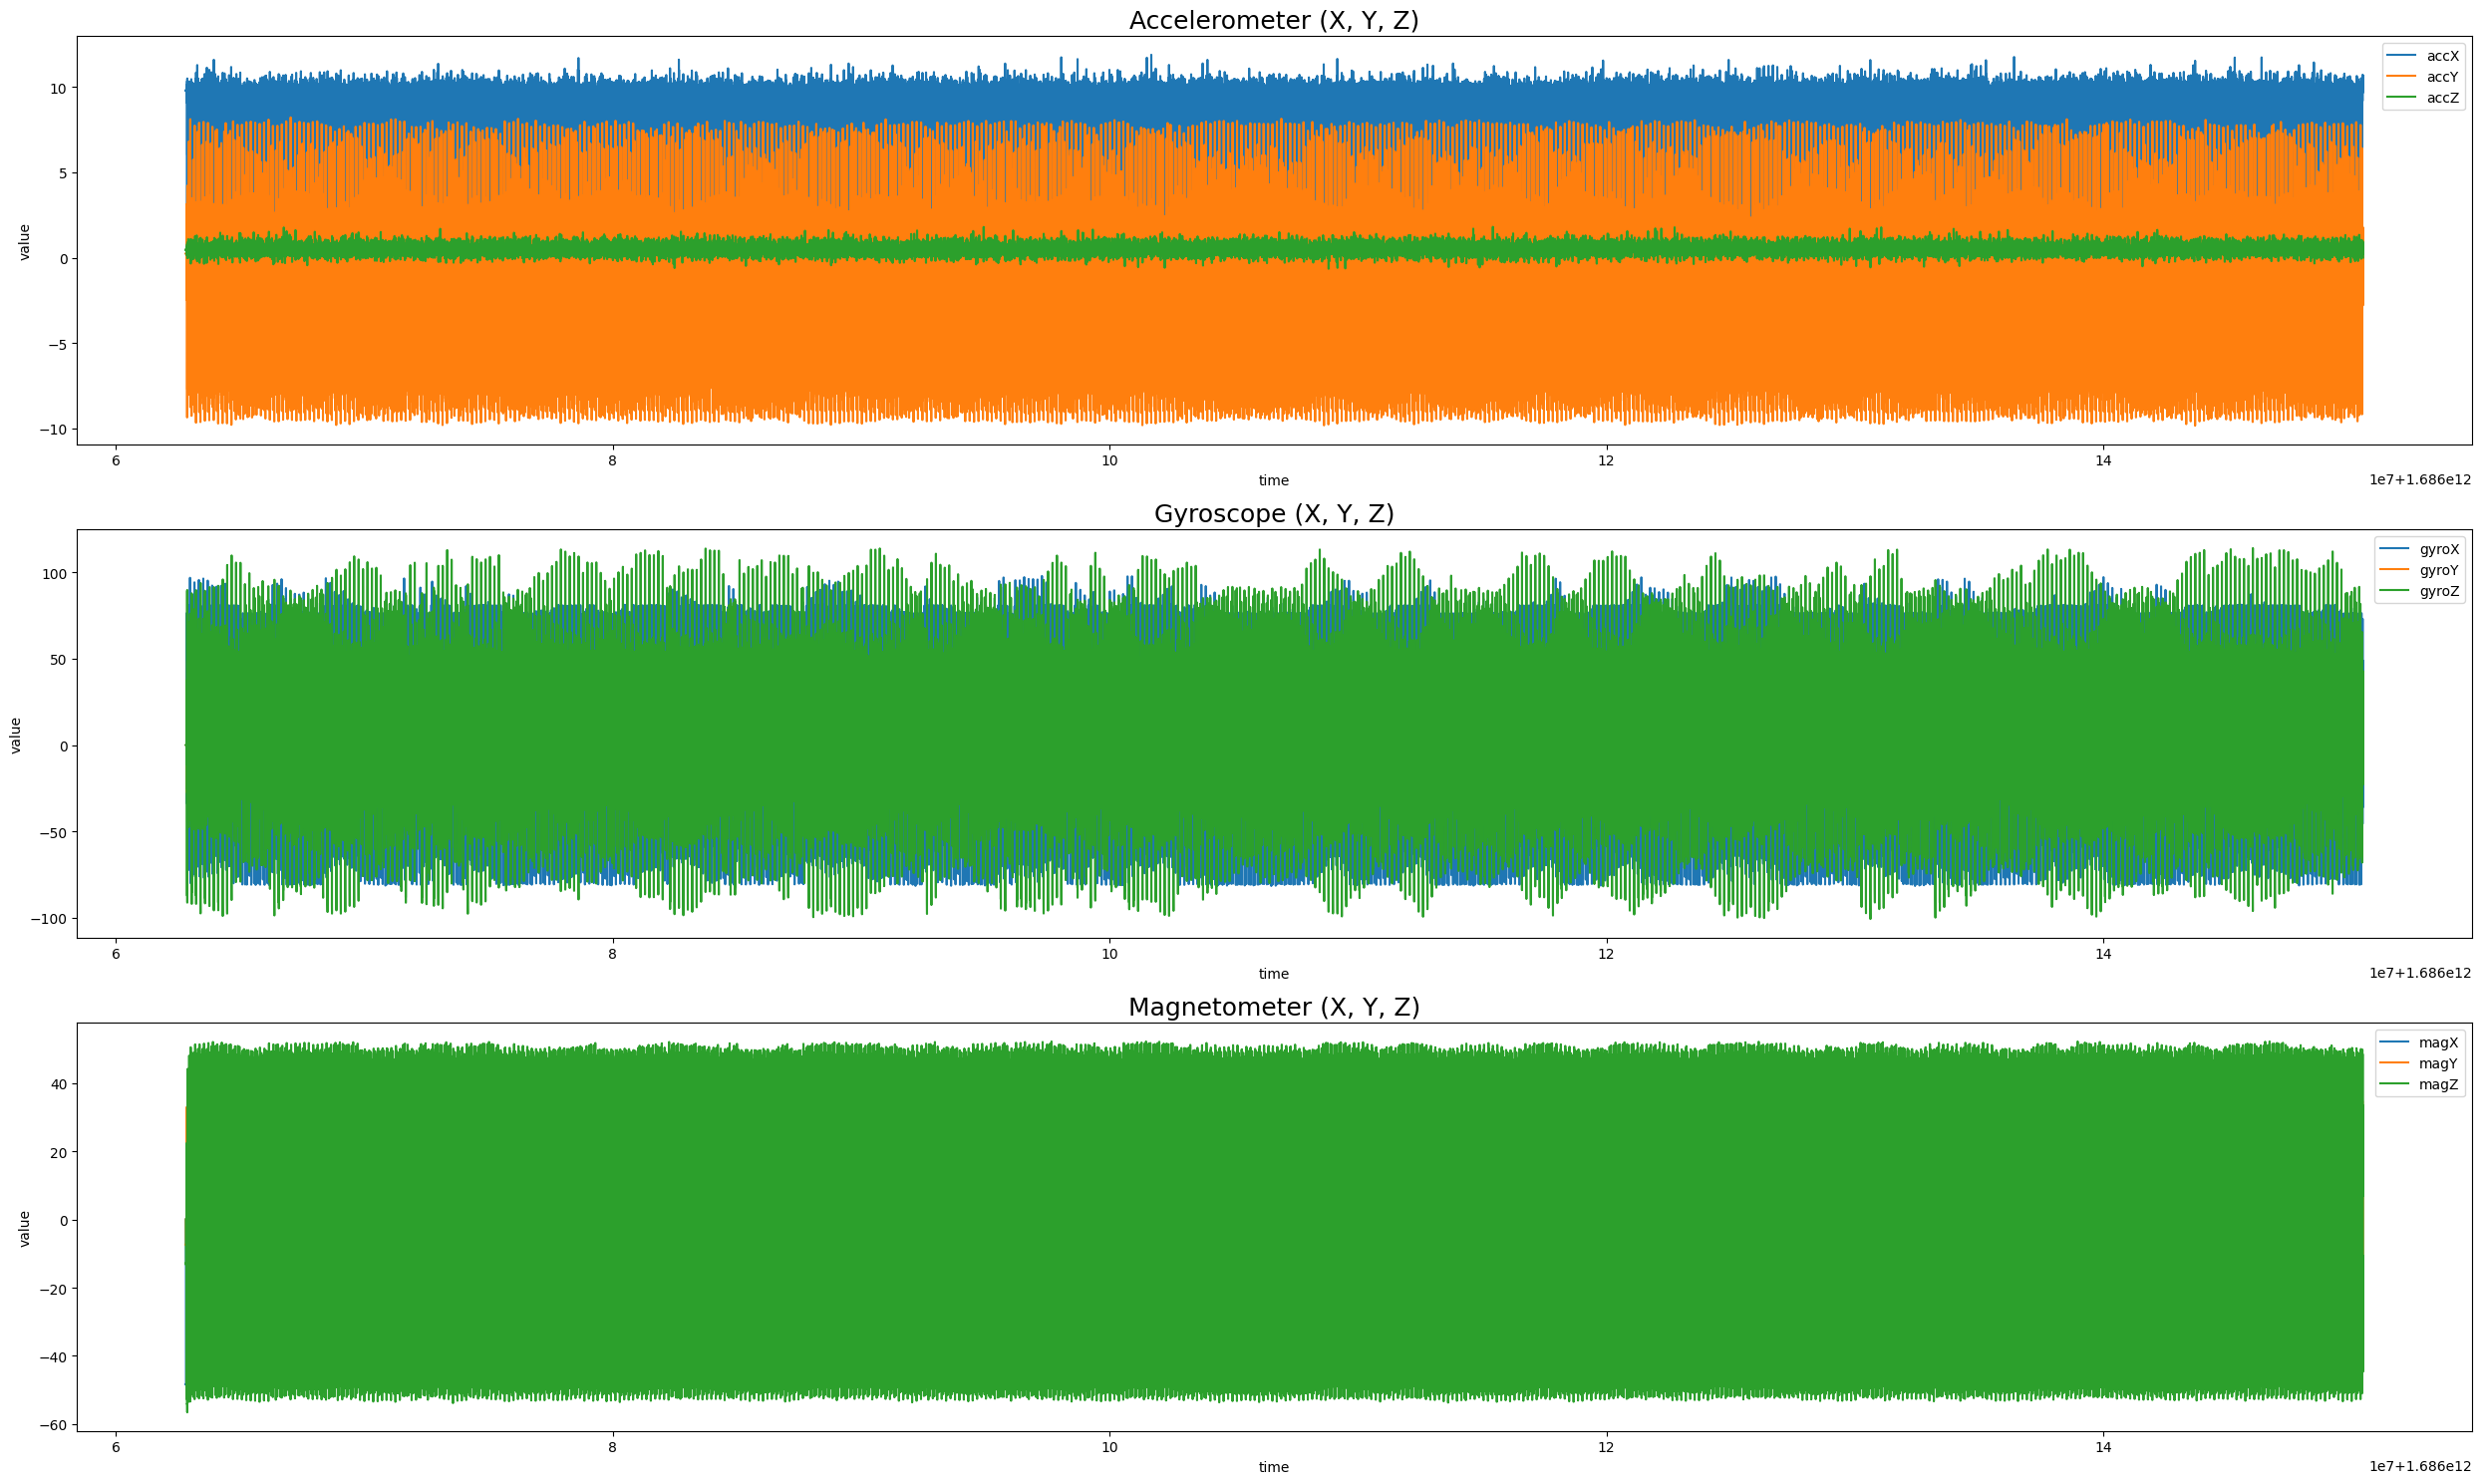

In [50]:
import matplotlib.pyplot as plt
def plotSensors(dfPlot, step=1000):
    df = dfPlot.iloc[::step]
    fig = plt.figure(figsize=(25, 15))

    # Helper to plot three axes in the same subplot
    def plotSensorsSameGraph(ax, cols, title, x="time"):
        for col in cols:
            ax.plot(df[x], df[col], label=col)
        ax.set_title(title, fontsize=18)
        ax.set_xlabel(x)
        ax.set_ylabel("value")
        ax.legend()

    # === Subplots ===
    ax1 = fig.add_subplot(3, 1, 1)
    plotSensorsSameGraph(ax1,
                         cols=["accX", "accY", "accZ"],
                         title="Accelerometer (X, Y, Z)")

    ax2 = fig.add_subplot(3, 1, 2)
    plotSensorsSameGraph(ax2,
                         cols=["gyroX", "gyroY", "gyroZ"],
                         title="Gyroscope (X, Y, Z)")

    ax3 = fig.add_subplot(3, 1, 3)
    plotSensorsSameGraph(ax3,
                         cols=["magX", "magY", "magZ"],
                         title="Magnetometer (X, Y, Z)")

    plt.tight_layout()
    plt.show()
plotSensors(df)